# 1-Zero-Shot-Mutation-Variant-DDD-ASD

Combined DDD and ASD variants for separation analysis, processed according to Zhou et al. methodology.

## Prerequisites

Run [00-Mutation-Datasets-Preprocessing.ipynb](./00-Mutation-Datasets-Preprocessing.ipynb) to download required data `ddd_asd_zhouetal_processed_am.csv`.

## Dataset Information
- **Dataset**: DDD_ASD
- **Path**: `/data/processed/mutation_datasets_latest/ddd_asd_zhouetal_processed_am.csv`
- **Task**: Zero-shot mutation effect prediction
- **Models**: Pretrained Encodon models (80M, 600M, 1B)
- **Evaluation**: ROC-AUC and PR-AUC metrics

### Key Features
- Multi-class analysis (DDD, ASD, control)
- Statistical separation testing
- Cross-disorder comparison

## 1. Import Libraries

In [2]:
import os
import pickle
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl
import torch
from tqdm import tqdm


warnings.filterwarnings("ignore")

# Machine learning libraries
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


plt.style.use("default")
sns.set_palette("husl")

# Add project paths
sys.path.append("..")

# Import Encodon-specific modules
from src.data.metadata import MetadataFields
from src.data.mutation_dataset import MutationDataset, collate_fn
from src.data.preprocess.mutation_pred import mlm_process_item
from src.inference.encodon import EncodonInference
from src.inference.task_types import TaskTypes


print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name()}")

✅ All libraries imported successfully!
PyTorch version: 2.8.0a0+34c6371d24.nv25.08
CUDA available: True
GPU device: NVIDIA RTX A6000


## 2. Load Encodon Models

In [ ]:
# Define checkpoint paths to try (update these to your actual paths!!!)
checkpoint_paths = {
    "80M": "/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1",
    "600m": "/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1",
    "1B": "/data/checkpoints/NV-CodonFM-Encodon-TE-Cdwt-1B-v1",
}
from src.utils.load_checkpoint import download_checkpoint


# download models if necessary
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-80M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-600M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-1B-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-1B-v1"
)

In [ ]:
def load_encodon_inference_model(checkpoint_path: str, device: str = "cuda") -> EncodonInference:
    """
    Load pretrained Encodon model using the inference wrapper.

    Args:
        checkpoint_path: Path to the pretrained checkpoint
        device: Device to load model on ('cuda' or 'cpu')

    Returns:
        EncodonInference object ready for mutation prediction
    """
    print(f"Loading Encodon model from: {checkpoint_path}")

    # Create inference wrapper
    inference_model = EncodonInference(
        model_path=checkpoint_path,
        task_type=TaskTypes.MUTATION_PREDICTION,
        use_transformer_engine=True,
    )

    # Configure the model (loads checkpoint and tokenizer)
    inference_model.configure_model()
    inference_model.eval()

    print(f"✅ Model loaded successfully on {device}")
    print(f"Model parameters: {sum(p.numel() for p in inference_model.model.parameters()):,}")
    print(f"Tokenizer vocabulary size: {inference_model.tokenizer.vocab_size}")

    return inference_model


model_loaded = False
encodon_models = {}

for size, checkpoint_path in checkpoint_paths.items():
    if os.path.exists(checkpoint_path):
        try:
            device = "cuda" if torch.cuda.is_available() else "cpu"
            model = load_encodon_inference_model(checkpoint_path, device=device)

            # Extract model name from path
            model_name = os.path.basename(os.path.dirname(os.path.dirname(checkpoint_path)))
            display_name = f"EnCodon ({size})"

            encodon_models[display_name] = {"model": model, "path": checkpoint_path, "device": device}
            print(f"✅ Successfully loaded {display_name} from: {checkpoint_path}")
            model_loaded = True
        except Exception as e:
            print(f"Failed to load from {checkpoint_path}: {e}")
            continue

if not model_loaded:
    print("❌ Could not load any Encodon model from the specified paths.")
    print("Please ensure a checkpoint exists or update the checkpoint_paths list.")
else:
    print(f"\n✅ Loaded {len(encodon_models)} models: {list(encodon_models.keys())}")

## 3. Define Plotting Functions

In [3]:
def get_size_key(model):
    """Helper to determine model size from its name - consistent with generate_results.py."""
    name = model.lower()
    if "80m" in name:
        return (0, "80M")
    elif "600m" in name:
        return (1, "600M")
    elif "1b" in name:
        return (2, "1B")
    else:
        return (99, "Unknown")


def calculate_mutation_separation_metrics(df, model_columns, dataset_info):
    """Calculate separation metrics using Mann-Whitney U test for DDD_ASD dataset."""
    metrics = {}
    cls_col = dataset_info["comparison_column"]
    model_columns = list(model_columns.items())
    if "baseline_column" in dataset_info:
        model_columns.append(("Baseline", dataset_info["baseline_column"]))

    for model_name, col in model_columns:
        metrics[model_name] = {}
        for expt_str, ctrl_str in dataset_info["comparisons"]:
            # Get predictions for experimental and control groups
            preds = df.loc[df[cls_col].str.contains(expt_str)].groupby("variant_id")[col].mean()
            ctrls = df.loc[df[cls_col].str.contains(ctrl_str)].groupby("variant_id")[col].mean()

            # Perform Mann-Whitney U test
            stat, p = mannwhitneyu(preds, ctrls)
            metrics[model_name][expt_str] = {
                "n_expt": len(preds),
                "n_ctrl": len(ctrls),
                "stat": stat,
                "p": p,
                "-log10(p)": -np.log10(p),
            }
    return metrics


def _assign_bar_colors_for_separation(df_group):
    """Assign unique colors to each bar based on model size - consistent with generate_results.py."""
    # Use same base colors as generate_results.py
    base_colors = {
        "80M": (0.0, 0.4, 0.8),  # Blue
        "600M": (1.0, 0.5, 0.0),  # Orange
        "1B": (0.0, 0.7, 0.0),  # Green
        "baseline": (0.1, 0.1, 0.1),  # almost black
        "other": (0.5, 0.5, 0.5),  # grey
    }

    # Assign a "size" column if not present
    if "size" not in df_group.columns:

        def extract_size(model_name):
            match = get_size_key(model_name)[1]
            if match in base_colors:
                return match
            elif "baseline" in model_name.lower():
                return "baseline"
            else:
                return "other"

        df_group = df_group.copy()
        df_group["size"] = df_group["model"].apply(extract_size)

    # Use -log10(p) to determine brightness: scale between 0.4 and 1.0
    log10p = df_group["-log10(p)"].values
    # Avoid NaN/inf
    log10p = np.nan_to_num(log10p, nan=0.0, posinf=0.0, neginf=0.0)

    bar_colors = []
    for i, size in enumerate(df_group["size"]):
        if size not in base_colors:
            base_color = base_colors["other"]
        else:
            base_color = base_colors[size]
        # For Baseline, always use the base color
        if size == "baseline":
            bar_colors.append(base_color)
            continue

        bar_colors.append(base_color)
    return bar_colors


def plot_separation_metrics_bar(df_metrics, dataset_name):
    """Plot separation metrics as bar plots for each group - ordered by model size."""
    for g in df_metrics["group"].unique():
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        df_group = df_metrics[df_metrics["group"] == g].copy()
        df_group["size"] = df_group["model"].apply(lambda x: get_size_key(x)[1])

        # Sort models by size (80M, 600M, 1B) then by name for consistent ordering
        def sort_key(row):
            size_order, size_str = get_size_key(row["model"])
            if "baseline" in row["model"].lower():
                return (999, row["model"])  # Put baseline at the end
            return (size_order, row["model"])

        df_group["sort_key"] = df_group.apply(sort_key, axis=1)
        df_group = df_group.sort_values("sort_key").reset_index(drop=True)
        df_group = df_group.drop("sort_key", axis=1)

        # Assign bar colors using the adapted function
        bar_colors = _assign_bar_colors_for_separation(df_group)

        # Create horizontal bar plot
        sns.barplot(
            y="model",
            x="-log10(p)",
            data=df_group,
            orient="h",
            hue="model",
            palette=bar_colors,
            legend=False,
            ax=ax,
            order=df_group["model"],  # Use the sorted order
        )

        # Add value annotations
        for i, (value, model) in enumerate(zip(df_group["-log10(p)"], df_group["model"])):
            ax.text(value + 0.1, i, f"{value:.2f}", va="center", ha="left", fontsize=10, color="black")

        ax.set_xlabel("-log10(p)", fontsize=12)
        ax.set_ylabel("Model", fontsize=12)

        # Get n_expt and n_ctrl from the first row
        n_expt = df_group["n_expt"].iloc[0] if "n_expt" in df_group.columns else None
        n_ctrl = df_group["n_ctrl"].iloc[0] if "n_ctrl" in df_group.columns else None
        title_str = f"{g.upper()}"
        if n_expt is not None and n_ctrl is not None:
            title_str += f" (n_expt={n_expt}, n_ctrl={n_ctrl})"
        ax.set_title(title_str, fontsize=14, fontweight="bold")

        plt.tight_layout()
        plt.savefig(f"{dataset_name}_{g}_separation.png", dpi=300, bbox_inches="tight", facecolor="white")
        plt.show()


print("✅ Separation analysis functions defined with consistent ordering and colors!")

✅ Separation analysis functions defined with consistent ordering and colors!


## 4. Load DDD_ASD Dataset

In [4]:
# Load DDD_ASD dataset
DATASET_CONFIG = {
    "key": "ddd_asd_zhouetal",
    "name": "DDD_ASD",
    "data_path": "/data/processed/mutation_datasets_latest/ddd_asd_zhouetal_processed_am.csv",
    "description": "Combined DDD and ASD variants for separation analysis, processed according to Zhou et al. methodology.",
}


def load_dataset(config):
    """Load and inspect the DDD_ASD dataset."""
    print(f"Loading {config['name']} dataset...")
    print(f"Path: {config['data_path']}")

    if not os.path.exists(config["data_path"]):
        print(f"❌ Dataset not found: {config['data_path']}")
        return None

    try:
        # Load data using polars then convert to pandas
        data = pl.read_csv(config["data_path"], ignore_errors=True).to_pandas()
        print(f"✅ Loaded {len(data)} variants")
        print(f"Shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")

        # Check for required columns
        required_cols = ["id", "ref_seq", "ref_codon", "alt_codon", "codon_position"]
        missing_cols = [col for col in required_cols if col not in data.columns]

        if missing_cols:
            print(f"⚠️ Missing columns: {missing_cols}")
        else:
            print("✅ All required columns present")

        # Show sample data
        display_cols = [
            col for col in ["id", "ref_codon", "alt_codon", "codon_position", "classification"] if col in data.columns
        ]
        print("\nSample data:")
        print(data[display_cols].head(3))

        return data

    except Exception as e:
        print(f"❌ Failed to load dataset: {e}")
        return None


# Load the dataset
dataset = load_dataset(DATASET_CONFIG)
print(f"\n📊 Dataset loaded: {dataset is not None}")

Loading DDD_ASD dataset...
Path: /data/validation/processed/ddd_asd_zhouetal_processed_am.csv
✅ Loaded 35339 variants
Shape: (35339, 31)
Columns: ['id', 'variant_id', 'tx_name', 'variant_type', 'chrom', 'pos', 'ref', 'alt', 'cdsStart', 'cdsEnd', 'tx_strand', 'var_rel_dist_in_cds', 'ref_seq', 'ref_codon', 'alt_codon', 'ref_aa', 'alt_aa', 'alt_seq', 'codon_position', 'Pheno', 'classification', 'chrom_right', 'pos_right', 'ref_right', 'alt_right', 'genome', 'uniprot_id', 'transcript_id', 'protein_variant', 'AlphaMissense', 'am_class']
✅ All required columns present

Sample data:
   id ref_codon alt_codon  codon_position classification
0   0       CGC       CAC             654            ddd
1   1       GGG       GCG             368            ddd
2   2       CGC       CAC             100            ddd

📊 Dataset loaded: True


## 5. Run Mutation Predictions

In [5]:
def run_mutation_predictions(models, data):
    """Run mutation predictions for DDD_ASD dataset."""
    if data is None or not models:
        print("❌ No data or models available")
        return {}

    print("\n=== RUNNING MUTATION PREDICTIONS FOR DDD_ASD ===")

    data_subset = data.copy()

    all_predictions = {}

    for model_name, model_info in models.items():
        print(f"\n--- Processing {model_name} ---")

        # Create temporary CSV file
        temp_csv_path = f"/tmp/ddd_asd_zhouetal_{model_name.replace(' ', '_')}_temp.csv"
        data_subset.to_csv(temp_csv_path, index=False)

        try:
            # Create MutationDataset
            mutation_dataset = MutationDataset(
                data_path=temp_csv_path,
                tokenizer=model_info["model"].tokenizer,
                process_item=mlm_process_item,
                context_length=2048,
                task="mlm",
                extract_seq=True,
                train_val_test_ratio=None,
            )

            # Create DataLoader
            dataloader = torch.utils.data.DataLoader(
                mutation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=0
            )

            # Run predictions
            all_ids = []
            all_likelihood_ratios = []

            model_info["model"].eval()
            model_info["model"].to(model_info["device"])
            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"{model_name} predictions"):
                    # Move batch to device
                    for key in batch:
                        if isinstance(batch[key], torch.Tensor):
                            batch[key] = batch[key].to(model_info["device"])

                    # Get predictions
                    output = model_info["model"].predict_mutation(batch, ids=batch[MetadataFields.ID])

                    all_ids.extend(output.ids)
                    all_likelihood_ratios.extend(output.likelihood_ratios)

            all_predictions[model_name] = {
                "ids": np.array(all_ids),
                "likelihood_ratios": np.array(all_likelihood_ratios),
            }

            print(f"✅ Completed {len(all_ids)} predictions")

        except Exception as e:
            print(f"❌ Failed predictions for {model_name}: {e}")
            continue
        finally:
            # Clean up temporary file
            if os.path.exists(temp_csv_path):
                os.remove(temp_csv_path)

            # Offload model from GPU to free memory
            if "model" in model_info and hasattr(model_info["model"], "cpu"):
                model_info["model"].cpu()
                print(f"🔄 Offloaded {model_name} from GPU")

            # Clear GPU cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                print(f"🧹 Cleared GPU cache after {model_name}")

    return all_predictions


# Run predictions if models and dataset are available
if "encodon_models" in locals() and "dataset" in locals() and dataset is not None:
    predictions = run_mutation_predictions(encodon_models, dataset)
    print(f"\n✅ Predictions completed for {len(predictions)} models")
else:
    print("❌ Cannot run predictions - missing models or dataset")
    predictions = {}


=== RUNNING MUTATION PREDICTIONS FOR DDD_ASD ===

--- Processing EnCodon (80M) ---


EnCodon (80M) predictions: 100%|████████████████████████████████████████████████████████████████| 1105/1105 [16:21<00:00,  1.13it/s]


✅ Completed 35339 predictions
🔄 Offloaded EnCodon (80M) from GPU
🧹 Cleared GPU cache after EnCodon (80M)

--- Processing EnCodon (600m) ---


EnCodon (600m) predictions: 100%|█████████████████████████████████████████████████████████████| 1105/1105 [1:09:02<00:00,  3.75s/it]


✅ Completed 35339 predictions
🔄 Offloaded EnCodon (600m) from GPU
🧹 Cleared GPU cache after EnCodon (600m)

--- Processing EnCodon (1B) ---


EnCodon (1B) predictions: 100%|███████████████████████████████████████████████████████████████| 1105/1105 [1:42:42<00:00,  5.58s/it]


✅ Completed 35339 predictions
🔄 Offloaded EnCodon (1B) from GPU
🧹 Cleared GPU cache after EnCodon (1B)

✅ Predictions completed for 3 models


## 6. Evaluate Results


=== EVALUATING DDD_ASD SEPARATION RESULTS ===
EnCodon (80M): 35339/35339 variants (100.0%)
EnCodon (600m): 35339/35339 variants (100.0%)
EnCodon (1B): 35339/35339 variants (100.0%)

Evaluation set: 35339 variants with complete predictions

📊 Separation Analysis Summary:

EnCodon (80M):
  DDD: -log10(p) = 29.13, p = 7.41e-30
    n_expt = 21219, n_ctrl = 3575
  ASD: -log10(p) = 6.33, p = 4.72e-07
    n_expt = 10621, n_ctrl = 3575

EnCodon (600m):
  DDD: -log10(p) = 30.09, p = 8.09e-31
    n_expt = 21219, n_ctrl = 3575
  ASD: -log10(p) = 7.12, p = 7.65e-08
    n_expt = 10621, n_ctrl = 3575

EnCodon (1B):
  DDD: -log10(p) = 34.75, p = 1.79e-35
    n_expt = 21219, n_ctrl = 3575
  ASD: -log10(p) = 7.55, p = 2.84e-08
    n_expt = 10621, n_ctrl = 3575

Baseline:
  DDD: -log10(p) = 46.34, p = 4.60e-47
    n_expt = 21219, n_ctrl = 3575
  ASD: -log10(p) = 6.88, p = 1.33e-07
    n_expt = 10621, n_ctrl = 3575


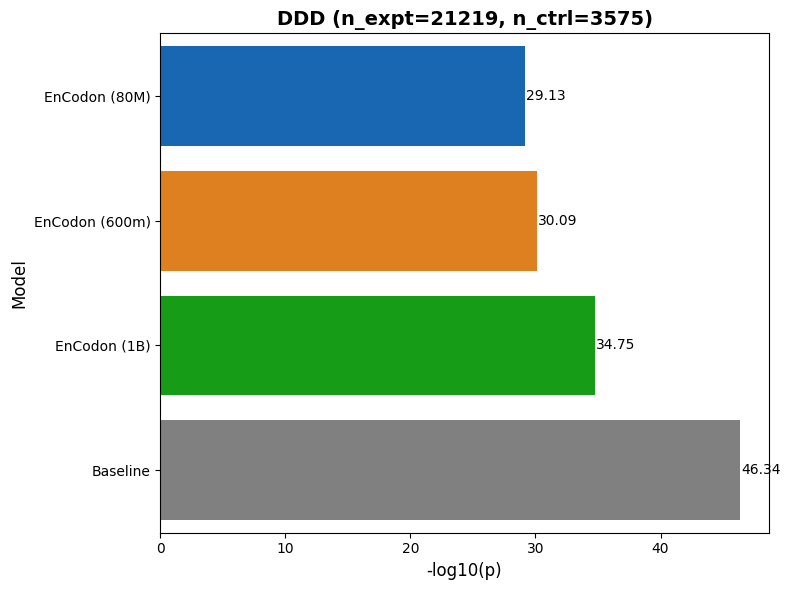

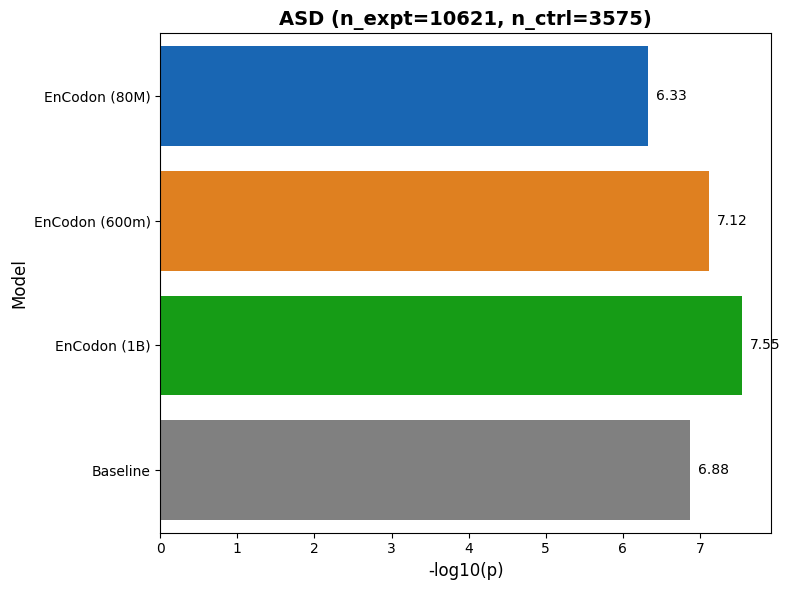

In [6]:
def evaluate_and_plot_ddd_asd_zhouetal_results(predictions, data):
    """Evaluate and plot separation results for DDD_ASD dataset."""
    if not predictions or data is None:
        print("❌ No predictions or data available")
        return

    print("\n=== EVALUATING DDD_ASD SEPARATION RESULTS ===")

    # Create evaluation dataframe
    eval_df = data.copy()
    model_columns = {}

    for model_name, pred_data in predictions.items():
        # Create mapping from ID to likelihood ratio
        id_to_lr = dict(zip(pred_data["ids"], pred_data["likelihood_ratios"]))

        # Add predictions to dataframe
        col_name = f"likelihood_ratios_{model_name}"
        eval_df[col_name] = eval_df["id"].map(id_to_lr)
        model_columns[model_name] = col_name

        # Report coverage
        coverage = eval_df[col_name].notna().sum()
        print(f"{model_name}: {coverage}/{len(eval_df)} variants ({coverage / len(eval_df) * 100:.1f}%)")

    # Filter to complete cases
    mask = pd.Series(True, index=eval_df.index)
    for col in model_columns.values():
        mask &= ~eval_df[col].isna()

    eval_df_filtered = eval_df[mask]
    print(f"\nEvaluation set: {len(eval_df_filtered)} variants with complete predictions")

    if len(eval_df_filtered) < 10:
        print("⚠️ Too few samples for reliable evaluation")
        return

    # Define dataset configuration for separation analysis
    dataset_info = {
        "comparison_column": "classification",
        "comparisons": [("ddd", "control"), ("asd", "control")],
        "baseline_column": "AlphaMissense",
    }

    # Calculate separation metrics
    metrics = calculate_mutation_separation_metrics(eval_df_filtered, model_columns, dataset_info)

    # Print summary
    print("\n📊 Separation Analysis Summary:")
    for model_name in metrics.keys():
        print(f"\n{model_name}:")
        for group, stats in metrics[model_name].items():
            print(f"  {group.upper()}: -log10(p) = {stats['-log10(p)']:.2f}, p = {stats['p']:.2e}")
            print(f"    n_expt = {stats['n_expt']}, n_ctrl = {stats['n_ctrl']}")

    # Create DataFrame for plotting
    records = []
    for model, groups in metrics.items():
        for group, stats in groups.items():
            record = {"model": model, "group": group}
            record.update(stats)
            records.append(record)

    df_metrics = pd.DataFrame(records)

    # Create plots
    plot_separation_metrics_bar(df_metrics, "DDD_ASD")

    return metrics


# Run separation analysis evaluation
if "predictions" in locals() and "dataset" in locals():
    results = evaluate_and_plot_ddd_asd_zhouetal_results(predictions, dataset)
else:
    print("❌ No predictions or dataset available for evaluation")

## 7. Save/Load Results

In [7]:
# Save and load functionality for DDD_ASD
def save_ddd_asd_zhouetal_results(predictions, filename="ddd_asd_zhouetal_results.pkl"):
    """Save DDD_ASD prediction results."""
    results_to_save = {
        "predictions": predictions,
        "dataset_key": "ddd_asd_zhouetal",
        "dataset_name": "DDD_ASD",
        "timestamp": datetime.now().isoformat(),
        "models": list(predictions.keys()) if predictions else [],
    }

    with open(filename, "wb") as f:
        pickle.dump(results_to_save, f)

    print(f"✅ DDD_ASD results saved to {filename}")
    print(f"   Models: {results_to_save['models']}")
    print(f"   Timestamp: {results_to_save['timestamp']}")


def load_ddd_asd_zhouetal_results(filename="ddd_asd_zhouetal_results.pkl"):
    """Load DDD_ASD prediction results."""
    if not os.path.exists(filename):
        print(f"❌ Results file not found: {filename}")
        return {}

    with open(filename, "rb") as f:
        results = pickle.load(f)

    print(f"✅ DDD_ASD results loaded from {filename}")
    print(f"   Models: {results.get('models', [])}")
    print(f"   Timestamp: {results.get('timestamp', 'Unknown')}")

    return results.get("predictions", {})


# Save current results if available
if "predictions" in locals() and predictions:
    save_ddd_asd_zhouetal_results(predictions)
    print("\n💾 DDD_ASD results saved!")
else:
    print("\n⚠️ No DDD_ASD results to save yet")

# Try to load existing results
if os.path.exists("ddd_asd_zhouetal_results.pkl"):
    saved_predictions = load_ddd_asd_zhouetal_results()
    if saved_predictions and not locals().get("predictions"):
        predictions = saved_predictions
        print("   Using saved results for analysis")

✅ DDD_ASD results saved to ddd_asd_zhouetal_results.pkl
   Models: ['EnCodon (80M)', 'EnCodon (600m)', 'EnCodon (1B)']
   Timestamp: 2025-10-22T07:11:09.278913

💾 DDD_ASD results saved!
✅ DDD_ASD results loaded from ddd_asd_zhouetal_results.pkl
   Models: ['EnCodon (80M)', 'EnCodon (600m)', 'EnCodon (1B)']
   Timestamp: 2025-10-22T07:11:09.278913
